Week 4 Progress: Datatypes and Graphing

In [1]:
# step 0: install package
#    py -m pip install matplotlib
#    py -m pip install seaborn

# import modules
import pandas as pd # alias as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")


# my own module
import thermogram_utilities

# import excel file as a pandas df
df = pd.read_excel("/Users/avery/OneDrive/Desktop/Fall_2023/STA485/tbl_lc/weekly_jupyter_nbs/lung_cancer_publication.xlsx")

# view the column datatypes
df.dtypes

sample_id                           object
pub_id                              object
T45                                float64
T45.1                              float64
T45.2                              float64
                                    ...   
Recurrence/Progression Location     object
Progression free survival          float64
overall survival                   float64
Alive.dead.                         object
personal history of cancer          object
Length: 538, dtype: object

The datatypes in this df:

&nbsp;&nbsp;&nbsp;&nbsp;float64: float (decimal value)

&nbsp;&nbsp;&nbsp;&nbsp;object: string or mixed datatype

To change a column type, use .astype

In [2]:
# convert id columns to strings, update df variable
df = df.astype({'sample_id' : 'string', 'pub_id' : 'string'})

# view the updated datatypes
df.dtypes

sample_id                          string[python]
pub_id                             string[python]
T45                                       float64
T45.1                                     float64
T45.2                                     float64
                                        ...      
Recurrence/Progression Location            object
Progression free survival                 float64
overall survival                          float64
Alive.dead.                                object
personal history of cancer                 object
Length: 538, dtype: object

In [3]:
# selecting columns: using column index. Selects all rows, and cols 1-452
# dataframe will contain only sample ids and t* cols
df_therms = df.iloc[: , list(range(453)) + [456]]

# pivot to long format
df_long = pd.melt(df_therms, id_vars=['sample_id', 'pub_id', 'CancerType'], var_name='temp', value_name='dsp' )

# remove the "T" and set temp column to numeric
df_long['temp'] = df_long['temp'].str.replace('T', '')
df_long = df_long.astype({"temp" : float})

df_long.head(5)

,sample_id,pub_id,CancerType,temp,dsp
0,C68401,L18,Squamous,45.0,0.002960
1,C69101,L22,NOS,45.0,0.000600
2,C68901,L21,Squamous,45.0,0.001320
3,C67801,L14,Adenocarcinoma,45.0,0.000786
4,C68801,L20,Large cell,45.0,0.000492


Data Visualization

Text(0.5, 1.0, 'Lung Cancer Thermograms')

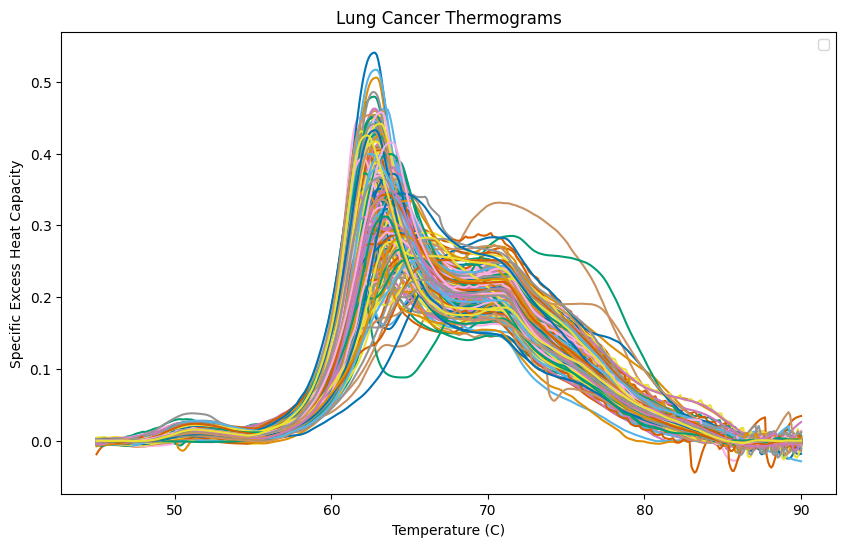

In [4]:
# graph with all thermograms on it
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=df_long, x='temp', y='dsp', hue='sample_id', palette='colorblind')
plt.legend([])
plt.xlabel('Temperature (C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Lung Cancer Thermograms')

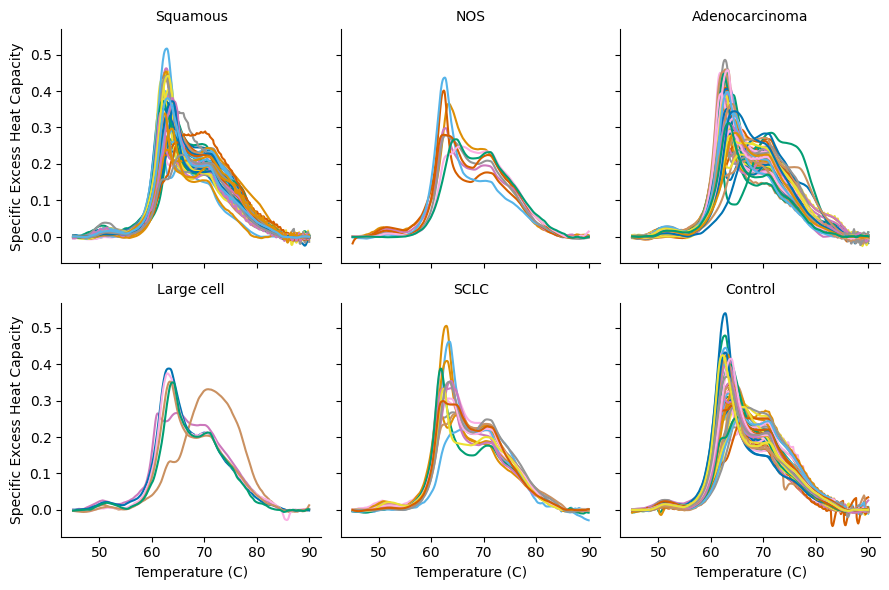

In [5]:
# multi-panel graph for each cancer type
#cancer_panel = sns.FacetGrid(df_therms, col='CancerType')
#cancer_panel.map_dataframe(sns.lineplot, x="temp", y="dsp", hue = 'sample_id')

#  replace missing values in 'CancerType' with 'Control'
df_long['CancerType'] = np.where(df_long['CancerType'].isna(), 'Control', df_long['CancerType'])

g = sns.FacetGrid(df_long, col="CancerType", col_wrap= 3, hue="sample_id", palette = 'colorblind')
g.map_dataframe(sns.lineplot, x="temp", y="dsp")
g.set_axis_labels("Temperature (C)", "Specific Excess Heat Capacity")
g.set_titles(col_template="{col_name}")


In [6]:
self = df_long
filter_col = 'CancerType'
temp_col = 'temp'
median_column = 'dsp'

# create median df
median_df = pd.DataFrame(columns=['temperature', 'median', 'type', 'upper_q', 'lower_q'])

# get all unique values in filter_col
    # get the column index of the filter column
#filter_col_index = self.columns.get_loc(filter_col)

    # get unique values from filter column
filter_vals = self[filter_col].unique()

# get all unique temps
    # get column index of temperature column
# temp_col_index = self.columns.get_loc(temp_col)

    # get unique values from filter column
temp_vals = self[temp_col].unique()

# loop through filter values
for i in filter_vals:

    # filter df for current filter val
    current_df = self[self[filter_col] == i]

    #print(current_df[filter_col].unique())

    # loop through each temperature
    for t in temp_vals:

        # filter to keep only current temperature
        current_temp_df = current_df[current_df[temp_col] == t]

        #print(current_temp_df[temp_col].unique)

        # calculate median for current temp/category
        median = current_temp_df[median_column].median()

        # calculate upper quantile
        lower_bound = np.percentile(current_temp_df[median_column], 2.5)

        # calculate lower quantile
        upper_bound = np.percentile(current_temp_df[median_column], 97.5)

        # append the new rows to the median df
        median_df.loc[len(median_df.index)] = [t, median, i, upper_bound, lower_bound] 


# return median dataframe

In [7]:
df_median = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')

# access documentation "docstring" by adding "?" after module.function
thermogram_utilities.median_curve?

Signature:
thermogram_utilities.median_curve(
    self,
    filter_col,
    temp_col,
    median_column,
)
Docstring:
Thermogram utility function that finds the median curve for a specified category (cancer type, progression).

Function calculates the median values for each temperature of a given class. It returns a dataframe with the median and 95% quantile values.

Parameters:
    self (pandas dataframe): pandas df with thermogram results in long format
    filter_col (str): Column that contains grouping parameter to find median values.
    temp_col (str): name of column that contains temperatures.
    median_column (str): specific excess heat capacity column to find median values.
    ...

Returns:Description
    return_type:  pandas df with median and quantile columns
    
Raises:
    ExceptionType: none
    ...

Examples:
    Provide example usage of the function or module.
    
    >>> df = thermogram_utilities.median_curve(df_long, 'CancerType', 'temp', 'dsp')
    Output: Datafr

Text(0.5, 1.0, 'Median Lung Cancer Thermograms')

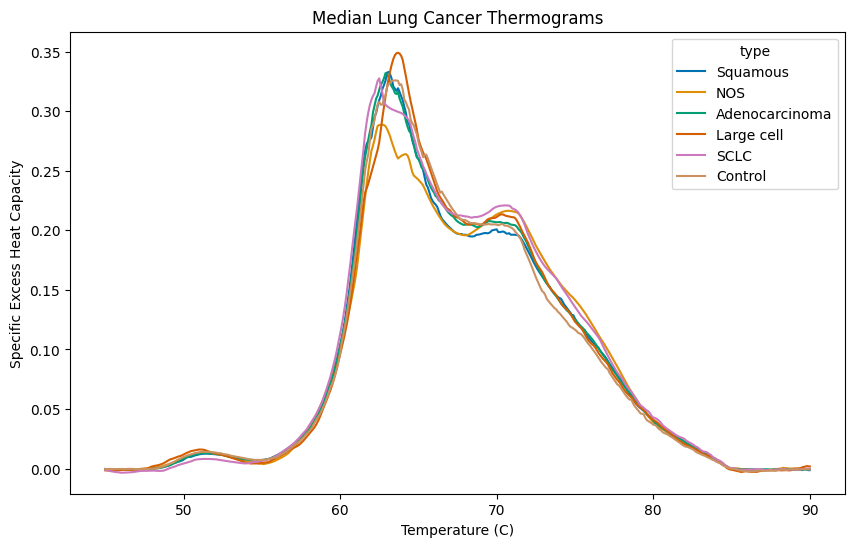

In [8]:
# median thermogram plot (all cancer types)
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
sns.lineplot(data=df_median, x='temperature', y='median', hue='type', palette='colorblind')
plt.xlabel('Temperature (C)')
plt.ylabel('Specific Excess Heat Capacity')
plt.title('Median Lung Cancer Thermograms')

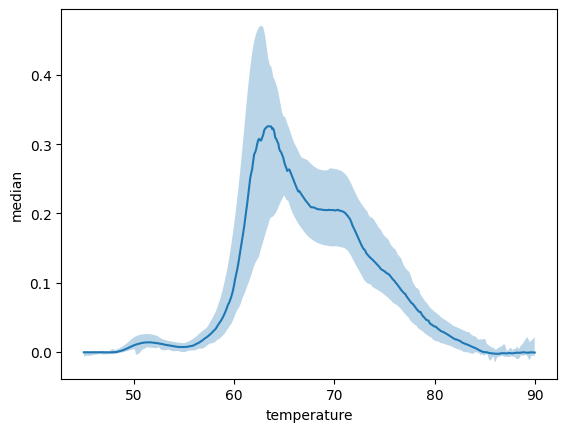

In [9]:
# get median therms and quantile ribbon (for one graph)
test_df = median_df[median_df['type'] == 'Control']
p = sns.lineplot(data=test_df, x='temperature', y='median', palette='colorblind')
plt.fill_between(test_df['temperature'], test_df['lower_q'], test_df['upper_q'], alpha = 0.3)



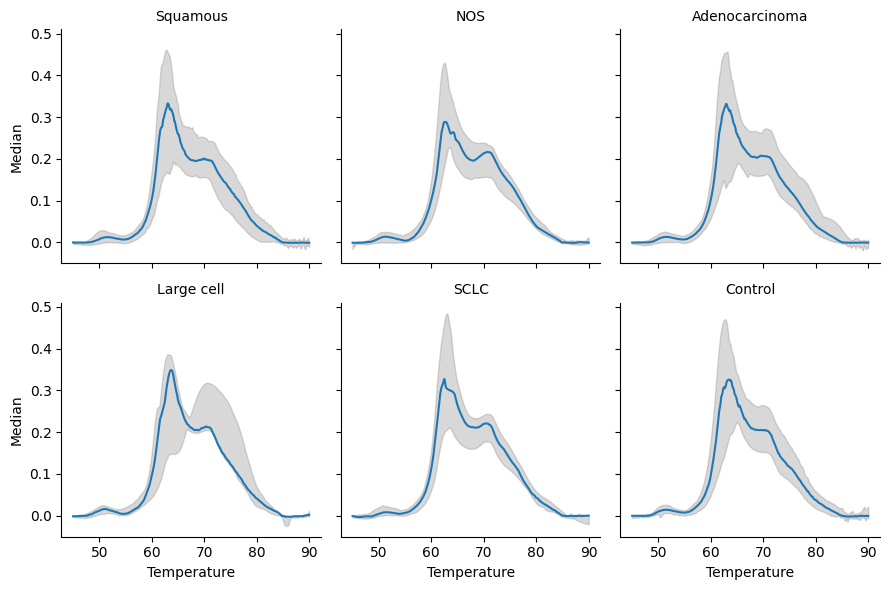

In [12]:

# courtesy of chatGPT
g = sns.FacetGrid(median_df, col="type", col_wrap= 3, palette = 'colorblind')


g.set_axis_labels("Temperature", "Median")
g.set_titles(col_template="{col_name}")

# Define a custom function to add the ribbon to each panel
def add_ribbon(**kwargs):
    ax = plt.gca()
    panel_data = kwargs.pop("data")  # Get the data specific to the current panel
    
    sns.lineplot(data=panel_data, x='temperature', y='median', ax=ax, palette='colorblind')
    ax.fill_between(panel_data['temperature'], panel_data['lower_q'], panel_data['upper_q'], alpha=0.3, color='gray')

# Use FacetGrid.map_dataframe to apply the custom function to each panel
g.map_dataframe(add_ribbon)

# Show the plot
plt.show()



